In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


In [35]:
# Initial phase guess 
class kvectorset:
    def __init__(self):
        self.vector_sets = {}
    
    def addharmonicdegree(self, set_number, magnitudes, angles):
        self.vector_sets[set_number] = {
            'magnitudes': magnitudes,
            'angles': angles
        }
    
    def get_maxdegree(self):
        return len(self.vector_sets)
    
    def get_magnitude(self, set_number):
        if set_number in self.vector_sets:
            return self.vector_sets[set_number]['magnitudes']
        else:
            raise ValueError(f"Set number {set_number} does not exist")
    
    def get_angle(self, set_number):
        if set_number in self.vector_sets:
            return self.vector_sets[set_number]['angles']
        else:
            raise ValueError(f"Set number {set_number} does not exist")

class OptimizedOutput:
    def __init__(self):
        self.slmphase = None
        self.stdint = None
        self.errors = []
        self.labels = []

    def set_slmphase(self, slmphase):
        self.slmphase = cp.array(slmphase)
    
    def get_slmphase(self):
        return self.slmphase

    def set_stdint(self, stdint):
        self.stdint = cp.array(stdint)
    
    def get_stdint(self):
        return self.stdint

    def add_error(self, error, label):
        self.errors.append(cp.array(error))
        self.labels.append(label)
    
    def get_error(self, index):
        if index < len(self.errors):
            return self.errors[index]
        else:
            raise IndexError("Error index out of range")

    def get_label(self, index):
        if index < len(self.labels):
            return self.labels[index]
        else:
            raise IndexError("Label index out of range")
    
    def get_all_errors(self):
        return self.errors
    
    def get_all_labels(self):
        return self.labels
    
    def add_error_and_label(self, error, label):
        self.add_error(error, label)
    
    def set_all(self, slmphase, stdint, errors, labels):
        self.set_slmphase(slmphase)
        self.set_stdint(stdint)
        self.errors = [cp.array(error) for error in errors]
        self.labels = labels

def sawtoothmake(t, width=1.0):
    """
    Generate a sawtooth wave.
    
    Parameters:
    - t: The input array (cupy.ndarray).
    - width: The width of the rising ramp as a proportion of the total cycle (default is 1.0).
    
    Returns:
    - Sawtooth wave values (cupy.ndarray).
    """
    t = cp.asarray(t)
    width = cp.asarray(width)
    
    # Perform modulo operation to ensure t is within one period
    t = cp.mod(t, 2 * cp.pi)
    
    # Generate the sawtooth wave
    return 2 * (t / (2 * cp.pi) - cp.floor(t / (2 * cp.pi) + (1 - width)))

def makeinitialkvectors(tweezers):
    """Determine the frequencies of input tweezers."""
    tweezers = tweezers / np.max(tweezers)
    pixel_coordinates = cp.argwhere(tweezers == 1)
    center = cp.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = cp.arctan2(vectors[:, 0], vectors[:, 1])
    for i in range(0,len(angles)):
        if vectors[:,1][i] < 0:
            angles[i] += cp.pi
    distances = cp.linalg.norm(vectors, axis=1)
    kmag = distances # / num_points * num_points   ?Why was this here? I don't know...
    
    kvectors = kvectorset()
    kvectors.addharmonicdegree(0,kmag, angles)
    
    return kvectors

def identifyharmonics(kvectors, maxdegree):
    """Indexing starts with 0! Given a list of kvectors, returns a list of all possible harmonics possible in a nested numpy array. So all first order vectors (
    the original kvectors set) will be in the 0th entry of the array, all second order vectors in the 1st entry, and so on until the max degree
    is reached. """

    expanded_kvectors = kvectorset()
    expanded_kvectors = kvectors

    for degree in range(maxdegree):
            if degree not in expanded_kvectors.vector_sets:
                raise ValueError(f"Set number {degree} does not exist")

            current_magnitudes = cp.array(expanded_kvectors.vector_sets[degree]['magnitudes'])
            current_angles = cp.array(expanded_kvectors.vector_sets[degree]['angles'])

            new_magnitudes = []
            new_angles = []

            # Compute pairwise addition and subtraction
            for i in range(len(current_magnitudes)):
                new_magnitudes.append(current_magnitudes + current_magnitudes[i])
                new_magnitudes.append(cp.abs(current_magnitudes - current_magnitudes[i]))

                new_angles.append(current_angles + current_angles[i])
                new_angles.append(cp.abs(current_angles - current_angles[i]))

            new_magnitudes = cp.around(cp.concatenate(new_magnitudes), 3)
            new_angles = cp.concatenate(new_angles)

            # Split the unique pairs back into magnitudes and angles
            unique_magnitudes, unique_indices = cp.unique(new_magnitudes, return_index=True)
            unique_angles = new_angles[unique_indices]
            
            expanded_kvectors.addharmonicdegree(degree + 1, unique_magnitudes, unique_angles)

    
    return expanded_kvectors
        
def frequenciestopixels_harmonicsonly(kvectors, tweezers):
    maxdegree = kvectors.get_maxdegree()
    center = cp.array(tweezers.shape) // 2
    tweezerlocations = cp.argwhere(tweezers > cp.max(tweezers) / 10)
    harmoniccoords = cp.array([[0,0]]) + center
    
    for degree in range(maxdegree):
        angles = kvectors.get_angle(degree)
        magnitudes = kvectors.get_magnitude(degree)
        xs = magnitudes * cp.cos(angles)
        ys = magnitudes * cp.sin(angles)
        pixelcoords = cp.column_stack((ys,xs))
        pixelcoords = cp.around(center + pixelcoords,0)
        harmoniccoords = cp.concatenate((harmoniccoords,pixelcoords), axis=0)
    
    mask = cp.ones(len(harmoniccoords), dtype=bool)
    for row in tweezerlocations:
        mask &= ~cp.all(harmoniccoords == row, axis=1)
    
    # Use the mask to filter array2
    result = cp.unique(harmoniccoords[mask])

    return result.astype(int)

## Below are the different offset options
def Off_None(kvector_mags, kvector_angles, tweezers):
    offsets = kvector_mags.copy() * 0
    return offsets

def Off_Rand(kvector_mags, kvector_angles, tweezers):
    offset =  cp.random.rand(*kvector_mags.shape) * cp.pi * 100
    return offset

def Off_Calc(kvector_mags, kvector_angles, tweezers):
    numtweezcols = cp.unique(cp.nonzero(tweezers)[0])
    numtweezrows = cp.unique(cp.nonzero(tweezers)[1])
    kx = kvector_mags * cp.cos(radians(kvector_angles))
    ky = kvector_mags * cp.sin(radians(kvector_angles))
    offsetx = kx*(kx-1)*2*cp.pi / 2 / (len(numtweezcols)-1) ## UPDATE: This might still not be correct - check if kx is actually num tweezers on width direction
    offsety = ky*(ky-1)*2*cp.pi / 2 / (len(numtweezrows)-1)
    offsetmag = cp.sqrt(offsetx*offsetx + offsety*offsety)
    offsetangle = cp.arctan(offsety / offsetx)
    offsetonk = offsetmag * cp.cos((offsetangle - radians(kvector_angles)))
    return offsetonk

## Wavetype calculators
def makecosine(k, offset, angle, num_points):
     # Set the parameters
    k = k * 1.5
    x = cp.linspace(0, 1, int(num_points*1.5))
    y = cp.linspace(0, 1, int(num_points*1.5))
    # Create a meshgrid
    x_mesh, y_mesh = cp.meshgrid(x, y)
    # Set the sawtooth pattern parameters
    # Generate the sawtooth pattern along the x direction
    sawtooth_pattern_x = cp.cos(2 * cp.pi * k * x_mesh + offset)
    plt.imshow(sawtooth_pattern_x.get())
    if cupyon:
        sawtooth_pattern = rotate_2d_array(sawtooth_pattern_x, angle)
    else:
        sawtooth_pattern = rotate_2d_array(sawtooth_pattern_x, angle)
    plt.imshow(sawtooth_pattern.get())

    sawtooth_pattern = sawtooth_pattern[int((num_points*0.5) // 2): int((num_points*2.5) //2), int((num_points*0.5) // 2): int((num_points*2.5) //2)]
    sawtooth_finalphase = sawtooth_pattern
    return sawtooth_finalphase * cp.pi

def makesawtooth(k, offset, angle, num_points):
     # Set the parameters
    k = k * 1.5
    x = cp.linspace(0, 1, int(num_points*1.5))
    y = cp.linspace(0, 1, int(num_points*1.5))
    # Create a meshgrid
    x_mesh, y_mesh = cp.meshgrid(x, y)
    # Set the sawtooth pattern parameters
    # Generate the sawtooth pattern along the x direction
    sawtooth_pattern_x = sawtoothmake(2 * cp.pi * k * x_mesh + offset)
    if cupyon:
        sawtooth_pattern = rotate_2d_array(sawtooth_pattern_x, angle)
    else:
        sawtooth_pattern = rotate_2d_array(sawtooth_pattern_x, angle)
    sawtooth_pattern = sawtooth_pattern[int((num_points*0.5) // 2): int((num_points*2.5) //2), int((num_points*0.5) // 2): int((num_points*2.5) //2)]
    sawtooth_finalphase = sawtooth_pattern
    return sawtooth_finalphase * cp.pi

def make_sawtooth1d(k, offset, num_points):
    # Calculate start and end indices of the required portion
    start_index = int((num_points * 0.5) // 2)
    end_index = int((num_points * 2.5) // 2)

    # Generate the sawtooth pattern along the x direction
    x = cp.linspace(0, 1, end_index - start_index, endpoint=False) * 1.5
    sawtooth_pattern_x = sawtoothmake(2 * cp.pi * k * x + offset)
    
    # Return the scaled pattern
    return sawtooth_pattern_x * cp.pi

def make_cosine1d(k, offset, num_points):
    # Calculate start and end indices of the required portion
    start_index = int((num_points * 0.5) // 2)
    end_index = int((num_points * 2.5) // 2)

    # Generate the sawtooth pattern along the x direction
    x = cp.linspace(0, 1, end_index - start_index, endpoint=False) * 1.5
    sawtooth_pattern_x = cp.cos(2 * cp.pi * k * x + offset)
    
    # Return the scaled pattern
    return sawtooth_pattern_x * cp.pi


# Phase optimizers

def Phase_MinJumps(flattenedkoffsets, flattenedks, wavetype):
    """Minimizes jumps betweens pixels, in other words minimizes the 1st derivative"""
    sum = 0
    flattenedkoffsets = cp.array(flattenedkoffsets)
    flattenedks = cp.array(flattenedkoffsets)
    # Perform element-wise computation without loops
    result = cp.sum(wavetype(flattenedks, flattenedkoffsets, len(flattenedks))) / len(flattenedks)  
    sum = (sum + cp.pi) % ( 2*cp.pi) - cp.pi
    ### Now to get the first derivative
    dsum = cp.abs(sum[:-1] - sum[1:])

    return cp.asnumpy(cp.sum(sum))
    
def Phase_MinAmp(flattenedkoffsets, flattenedks, wavetype):
    sum = 0
    flattenedkoffsets = cp.array(flattenedkoffsets)
    flattenedks = cp.array(flattenedkoffsets)
    result = cp.sum(wavetype(flattenedks, flattenedkoffsets, len(flattenedks))) / len(flattenedks)  
    sum = (sum + cp.pi) % ( 2*cp.pi) - cp.pi
    # stdeviation = std(sum)
    sum = cp.where(cp.abs(sum) < 0.55, 0, sum)
    sum = abs(sum*10)**3
    
    return cp.asnumpy(cp.sum(sum))

# Calculate the first phase guess. Might be used for phase optimization
def create_phasemap(kvectors, offsets, wavetype=makesawtooth, opton=False, opttype = Phase_MinJumps, optmethod='BFGS', optiter=5):
    """Create phase map with waves of specified type. Currently supports Cosine or Sawtooth."""
    kmags = kvectors.get_magnitude(0)
    kangles = kvectors.get_angle(0)
    sum = 0
    for i in range(len(kmags)):
        sum = cp.add(cp.divide(wavetype(kmags[i], offsets[i], kangles[i], numpixels), len(kmags)),sum)
    sum = (sum + cp.pi) % (2 * cp.pi) - cp.pi
    if opton:
        flattenedks = kmags / cp.cos(radians(kangles))
        flattenedkoffsets = offsets / cp.cos(radians(kangles))
        if wavetype == makesawtooth:
            optimizerwave = make_sawtooth1d
        elif wavetype == makecosine:
            optimizerwave = make_cosine1d

        optimize_offsets = minimize(opttype, cp.asnumpy(offsets), args=(cp.asnumpy(flattenedks), optimizerwave), method=optmethod, options={'maxiter':optiter})
        # optimize_offsets = minimize(opttype, offsets, args=(flattenedks, optimizerwave), method=optmethod, options={'maxiter':optiter})

        optimized_offsets = optimize_offsets.x
        sum = cp.zeros((numpixels, numpixels))
        for i in range(len(kmags)):
            sum = cp.add(cp.divide(wavetype(kmags[i], optimized_offsets[i], kangles[i], numpixels), len(kmags)),sum)
        sum = (sum + cp.pi) % (2 * cp.pi) - cp.pi
        
    return sum

# Tweezer generation

def createtweezers_grid(blankinput, spacing, xnum, ynum):
    """Creates delta function at tweezer locations. blankinput is a blank input array to 
    initialize tweezer in, spacing is the pixel spacing between tweezers, and xnum and ynum are the 
    number of tweezers in the respective directions. Auto-centered and created."""
    simplegrating = cp.zeros(cp.shape(blankinput))
    ysize = cp.shape(blankinput)[0]
    xsize = cp.shape(blankinput)[1]

    for i in range(xsize // 2 + xsize // 10, xsize // 2 + xsize // 10+ spacing*xnum ):
        for j in range(ysize//2 - spacing * ynum // 2 ,ysize // 2 + spacing*ynum // 2):
            pixcoord = 0
            distj1 = j  % spacing
            disti1 = i  % spacing
            distj2 = (spacing - j) % spacing
            disti2 = (spacing - i) % spacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            xrad = 1
            yrad = 1
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating

def derivephase(costfunction, targetintensity, initialphase, iterations, magnification = 1, harmonicremoval = False, badharmonics_pixelcoords=[], beamtype="Constant", sigma=1, mu = 1):
    """All inputs are assumed to be of the same dimensionality, 1300 by 1300. Note that magnification adds on to the target, so
    if target is already 3900 by 3900 magnification of 2 will make the simulation space much(!) larger. Beamtypes available are Gaussian or Constant."""
    # Remember, the calculation region is only numpixels by numpixels
    targetintensity = targetintensity / cp.max(targetintensity)
    # Just in case we're using a highly precise target (so not delta function)
    targetmagnification = cp.shape(targetintensity)[0] // numpixels
    targetintensity = expand(targetintensity, magnification)
    magnification = targetmagnification * magnification
    slmphase = set_circlemask(expand(initialphase, magnification), numpixels *magnification)
    inputbeam = set_circlemask(createbeam(beamtype, numpixels * magnification, sigma, mu), numpixels * magnification)
    slmplane = join_phase_ampl(slmphase, inputbeam)
    
    weights=cp.ones((numpixels * magnification, numpixels*magnification))
    weights_previous = targetintensity.copy()
    
    # stdinttracker = [] # For use in error calculations
    tweezerlocation = cp.where(targetintensity == 1)
    err_maxmindiff = []
    err_uniformity = []
    err_powereff = []

    for _ in range(iterations):
        startingpower = cp.sum(cp.abs(slmplane)**2)
        fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
        fourierintensity = cp.square(cp.abs(fourierplane))
        stdint = cp.divide(fourierintensity, cp.max(fourierintensity))

        err_maxmindiff.append(Err_MaxMinDiff(stdint, tweezerlocation))
        err_uniformity.append(Err_Uniformity(stdint, targetintensity))
        err_powereff.append(Err_PowerEff(stdint, tweezerlocation))

        weights = costfunction(weights, weights_previous, targetintensity, stdint, harmonicremoval, badharmonics_pixelcoords)
        weights_previous = weights.copy()
        ## This might be a bit confusing, but weights is now the amplitude and we re-combine it with the phase to get the next iteration
        fourierangle = cp.angle(fourierplane)
        fourierplane = join_phase_ampl(fourierangle, weights)
        slmplane = cp.fft.ifftshift(cp.fft.ifft2(cp.fft.ifftshift(fourierplane), norm="ortho"))     
        endingpower = cp.sum(cp.abs(slmplane)**2)
        slmplane = cp.multiply(cp.divide(slmplane, endingpower), startingpower)
        slmplane_numpixels = slmplane.copy()
        slmplane_numpixels = cp.mean(slmplane_numpixels.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))
        
        slmphase = undiscretize_phase(discretize_phase(set_circlemask(cp.angle(slmplane_numpixels), numpixels)))
        readout_slmphase = slmphase.copy()
        slmplane = join_phase_ampl(expand(slmphase, magnification), inputbeam)
    
    
    
    errors = [err_maxmindiff, err_uniformity, err_powereff]
    labels = ["MaxMinDiff","Uniformity", "Power Efficiency"]

    readout = OptimizedOutput()
    readout.set_all(readout_slmphase, stdint, errors, labels)
    
    return readout
    
def simulatefourier(tweezerphase, magnification=3, beamtype="Constant", sigma=1, mu=1):
    slmphase = set_circlemask(expand(tweezerphase, magnification), numpixels *magnification)
    inputbeam = set_circlemask(createbeam(beamtype, numpixels * magnification, sigma, mu), numpixels * magnification)
    slmplane = join_phase_ampl(slmphase, inputbeam)   
    fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
    fourierintensity = cp.square(cp.abs(fourierplane))
    stdint = cp.divide(fourierintensity, cp.max(fourierintensity))
    return stdint

## Algorithm subfunctions

def discretize_phase(phase):
    phase=cp.around((phase+cp.pi)*255/(2*cp.pi), decimals=0 )
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*cp.pi)-cp.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    image = inputmatrix
    image[cp.sqrt((cp.arange(image.shape[0])[:,None] - image.shape[0]//2)**2 + (cp.arange(image.shape[1]) - image.shape[1]//2)**2) > radius] = 0
  
    return image

def createbeam(beamtype, size, sigma=1, mu = 1):
    blank = cp.zeros((size,size), dtype=complex)
    if beamtype == "Gaussian":
        x, y = cp.meshgrid(cp.linspace(-1,1,size), cp.linspace(-1,1,size))
        d = cp.sqrt(x*x+y*y)
        g = cp.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
        blank = g
    elif beamtype == "Constant":
        blank[:,:] = 1
    ### More support may be added in the future.
    return blank
    
### Cost functions

def Pen_DeltaSqrt(w,w_prev,target_im,std_int, harmonicremoval=False, harmoniccoords=[]):
    if harmonicremoval:
        w[target_im==1] = cp.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
        w[harmoniccoords] = 0
    else:
        w[target_im==1] = cp.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def Pen_Sqrt(w,w_prev,target_im,std_int, harmonicremoval=False, harmoniccoords=[]):
    if harmonicremoval:
        w[target_im!=0] = cp.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
        w[harmoniccoords] = 0
    else:
        w[target_im!=0] = cp.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
    return (w)

def Pen_Exp(w,w_prev,target_im,std_int, harmonicremoval=False, harmoniccoords=[]):
    if harmonicremoval:
        w[target_im!=0] = cp.power(target_im[target_im!=0] / std_int[target_im!=0],3) * w_prev[target_im!=0]
        w[harmoniccoords] = 0
    else:
        w[target_im!=0] = cp.power(target_im[target_im!=0] / std_int[target_im!=0],3) * w_prev[target_im!=0]
    return (w)

# (Experimental) some more cost functions
def weights(w,w_prev,target_im,std_int, harmonicremoval=False, harmoniccoords=[]): # This weight function works only where the intensity == 1 (discrete tweezers)

    w[target_im==1] = cp.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def weights_gaussian(w,target_im,w_prev,std_int, harmonicremoval = False): # This weight function works only where the intensity == 1 (discrete tweezers)
    w[target_im!=0] = cp.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
    return (w)

def weightintensity_lukin(target, target_prev, std_int, target_im, harmonicremoval = False):
    target[target_im==1] = cp.sqrt((cp.mean(std_int[target_im==1]) / (std_int[target_im==1]+0.001))) * target_prev[target_im==1]
    return target

### Error Metrics
def Err_MaxMinDiff(stdints, coordinates):
    # for stdint in stdints:
    #     max = cp.max(stdint[coordinates]) #Max value of the obtained intensity at the tweezers position
    #     min = cp.min(stdint[coordinates]) #Min value of the obtained intensity at the tweezers position
    #     errors.append((max-min)/(max+min))
    max = cp.max(stdints[coordinates]) #Max value of the obtained intensity at the tweezers position
    min = cp.min(stdints[coordinates]) #Min value of the obtained intensity at the tweezers position
    
    # errors = []
    # errors.append((max-min)/(max+min))
    errors = (max-min)/(max+min)

    return errors

def Err_Uniformity(stdints, tweezers):
    target_im = tweezers / cp.max(tweezers)
    tweezerloc = cp.argwhere(target_im == 1)
    # for stdint in stdints:
    #     errors.append(cp.std(stdint[tweezerloc]))
    # errors = []
    # errors.append(cp.std(stdints[tweezerloc]))

    errors = cp.std(stdints[tweezerloc])
    return errors

def Err_PowerEff(stdints, coordinates, n = 1):
    # expanded_coords = set()

    # for coord in coordinates:
    #     # Generate a range of offsets from -n to n for each dimension
    #     ranges = [range(max(0, c - n), min(shape[i], c + n + 1)) for i, c in enumerate(coord)]
        
    #     # Use product to get all combinations of these ranges
    #     for offset in product(*ranges):
    #         expanded_coords.add(offset)

    errors = []
    
    # for stdint in stdints:
    #     netpower = cp.sum(cp.abs(stdint)**2)
    #     tweezerpower = cp.sum(cp.abs(stdint[expanded_coords])**2)
    #     errors.append(tweezerpower / netpower)

    netpower = cp.sum(cp.abs(stdints)**2)
    tweezerpower = cp.sum(cp.abs(stdints[coordinates])**2)
    
    # errors = []
    # errors.append(tweezerpower / netpower)

    errors = tweezerpower / netpower
    
    return errors

# Quality of life

def zoomin(array, cutoff=1.5):
    """zooms into the region of interest, threshold is just the average pixel value"""
    threshold = cp.mean(array) * cutoff
    coordinates = cp.argwhere(array > threshold)
    if coordinates.size > 0:
        min_y, min_x = cp.min(coordinates, axis=0)
        max_y, max_x = cp.max(coordinates, axis=0)
    else:
        min_y = min_x = max_y = max_x = None

    zoomedarray = array[min_y-20:max_y+20, min_x-20:max_x+20]
    
    return zoomedarray

def zoomin_getcoords(array):
    """zooms into the region of interest, threshold is just the average pixel value"""
    threshold = cp.mean(array) * 1.5
    coordinates = cp.argwhere(array > threshold)
    if coordinates.size > 0:
        min_y, min_x = cp.min(coordinates, axis=0)
        max_y, max_x = cp.max(coordinates, axis=0)
    else:
        min_y = min_x = max_y = max_x = None
    
    return [min_y-20,max_y+20, min_x-20,max_x+20]

def expand(array, multiplier=3):
    """ expands array based on multiplier for use in GWS algorithm or fourier imaging"""
    expanded_array = cp.kron(array, cp.ones((multiplier, multiplier)))
    return expanded_array

def norm(matrix):
    min=cp.min(matrix);max=cp.max(matrix)
    return((matrix-min)/(max-min))

def join_phase_ampl(phase,ampl):
    tmp=cp.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = cp.multiply(ampl,cp.exp(phase*1j))
    return tmp

def remove0thorder(stdint):
    numpixels_std = cp.shape(stdint)[0]
    stdint[numpixels_std // 2 - numpixels_std // 11: numpixels_std // 2 + numpixels_std // 11, numpixels_std // 2 - numpixels_std // 11: numpixels_std // 2 + numpixels_std // 11] = 0
    return stdint

def removeleftside(stdint):
    numpixels_std = cp.shape(stdint)[0]
    stdint[0: numpixels_std, 0: numpixels_std // 2 + numpixels_std // 15] = 0
    return stdint

def removerightside(stdint):
    numpixels_std = cp.shape(stdint)[0]
    stdint[0: numpixels_std,numpixels_std // 2 + numpixels_std // 15:numpixels_std] = 0
    return stdint

def removeedges(stdint):
    numpixels_std = cp.shape(stdint)[0]
    stdint[0: numpixels_std,   0:numpixels_std // 8] = 0
    stdint[0: numpixels_std, numpixels_std - numpixels_std // 8: numpixels_std] = 0
    stdint[0:numpixels_std // 8, 0: numpixels_std] = 0
    stdint[numpixels_std - numpixels_std // 8: numpixels_std, 0: numpixels_std] = 0
    return stdint

def rotate_2d_array(arr, theta, order=1):
    """
    Rotate a 2D intensity array by a certain angle in radians around its center without reshaping using GPU acceleration.
    
    Parameters:
    - arr: 2D intensity array (cupy.ndarray).
    - theta: The angle in radians by which to rotate the array.
    - order: The interpolation order (0: nearest, 1: bilinear).
    
    Returns:
    - Rotated array (cupy.ndarray).
    """
    # Get dimensions of the array
    h, w = arr.shape
    
    # Calculate the center of the array
    center_y, center_x = h // 2, w // 2
    
    # Create output array
    rotated_arr = cp.zeros_like(arr)
    
    # Create coordinate grid
    y, x = cp.indices((h, w))
    
    # Center the coordinates
    y = y - center_y
    x = x - center_x
    
    # Flatten the arrays
    y_flat = y.ravel()
    x_flat = x.ravel()
    
    # Create rotation matrix
    cos_theta = cp.cos(theta)
    sin_theta = cp.sin(theta)
    rotation_matrix = cp.array([cp.array([cos_theta, -sin_theta]), cp.array([sin_theta, cos_theta])])
    
    # Stack coordinates as rows of a single array
    coords = cp.vstack((y_flat, x_flat))
    
    # Apply the rotation matrix
    new_coords = rotation_matrix @ coords
    
    # Translate coordinates back to the original frame
    new_y, new_x = new_coords
    
    # Round coordinates to the nearest integer
    new_y = cp.around(new_y,0).astype(int) + center_y
    new_x = cp.around(new_x,0).astype(int) + center_x
    
    # Filter out-of-bounds coordinates
    valid_mask = (new_y >= 0) & (new_y < h) & (new_x >= 0) & (new_x < w)
    
    # Assign the rotated values
    rotated_arr[y_flat[valid_mask] + center_y, x_flat[valid_mask] + center_x] = arr[new_y[valid_mask], new_x[valid_mask]]
    
    return rotated_arr

# Visualization
def create_3d_bar_plot(data, title='Tweezer Intensities', xlabel='X-axis', ylabel='Y-axis', zlabel='Intensity'):
    """
    Creates a 3D bar plot from a 2D array of intensity values.

    Parameters:
    - data: 2D array of intensity values.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - zlabel: Label for the z-axis.

    Returns:
    - fig: Matplotlib Figure object containing the 3D plot.
    - stats: Dictionary containing some statistics.
    """
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get the shape of the data
    num_rows, num_cols = data.shape

    # Create grid of x, y coordinates
    x, y = np.meshgrid(np.arange(num_cols), np.arange(num_rows))

    # Flatten the x, y, and data arrays
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = 0.8  # Width and depth of the bars
    dz = data.flatten()

    # Create the 3D bars
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    # Calculate some statistics
    stats = {
        'mean': np.mean(data),
        'max': np.max(data),
        'min': np.min(data)
    }

    return fig, stats

import matplotlib.pyplot as plt

def create_combined_line_plot(names, datasets, title='Error Convergence', xlabel='Iterations', ylabel='Error'):
    """
    Creates a combined line plot from multiple datasets.

    Parameters:
    - names: List of names for each dataset.
    - datasets: List of datasets, each dataset being a list or array of values.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.

    Returns:
    - fig: Matplotlib Figure object containing the plot.
    """
    # Check if names and datasets have the same length
    if len(names) != len(datasets):
        raise ValueError("The length of names and datasets must be the same.")
    
    # Check if all datasets are of equal length
    dataset_length = len(datasets[0])
    if not all(len(dataset) == dataset_length for dataset in datasets):
        raise ValueError("All datasets must be of equal length.")
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each dataset
    for name, data in zip(names, datasets):
        ax.plot(data, label=name)
    
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Add a legend
    ax.legend()
    
    # Add a grid
    ax.grid(True)
    
    return fig

import matplotlib.pyplot as plt

def combine_figures(figures, sizes=None, num_cols=2):
    """
    Combines multiple Matplotlib figures into one figure with a specified number of columns.

    Parameters:
    - figures: List of Matplotlib Figure objects to be combined.
    - sizes: List of tuples specifying the size (width, height) for each figure. Default size will be used if None.
    - num_cols: Number of columns in the combined figure layout.

    Returns:
    - combined_fig: Matplotlib Figure object containing the combined layout.
    """
    # Determine the number of rows needed
    num_rows = (len(figures) + num_cols - 1) // num_cols

    # Create a new figure to combine all subplots
    combined_fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 6 * num_rows))

    # Flatten the axes array for easy iteration, even if there is only one row or one column
    if num_rows == 1 and num_cols == 1:
        axes = [axes]
    elif num_rows == 1 or num_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flat

    # Loop through figures and sizes, and add each figure as a subplot in the combined figure
    for idx, (ax, fig) in enumerate(zip(axes, figures)):
        if sizes and idx < len(sizes):
            fig.set_size_inches(sizes[idx])
        
        for original_ax in fig.get_axes():
            # Copy lines
            for line in original_ax.get_lines():
                ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
            
            # Copy the title, labels, and legend
            ax.set_title(original_ax.get_title())
            ax.set_xlabel(original_ax.get_xlabel())
            ax.set_ylabel(original_ax.get_ylabel())
            ax.legend()
        
    # Hide any unused subplots
    for ax in axes[len(figures):]:
        ax.axis('off')

    plt.tight_layout()
    return combined_fig


In [31]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff

tweezerarray = createtweezers_grid(cp.zeros((numpixels*5,numpixels*5)), 3, 20,20 )
# plt.imshow(zoomin(expand(tweezerarray,1)))

In [33]:
# Get the kvectors from the tweezer array
kvector_tweezers = makeinitialkvectors(tweezerarray)
harmonics = identifyharmonics(kvector_tweezers, 1)
harmonics_coordinates = frequenciestopixels_harmonicsonly(harmonics, tweezerarray)
# Calculate offsets
kvector_initoffsets = Off_Calc(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)

In [34]:
# Get initial phase guess
initialphaseguess = create_phasemap(kvector_tweezers, kvector_initoffsets, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)

In [40]:
# Derive necessary phase for tweezers
optimizedout  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess, 50,1,False,harmonics_coordinates)

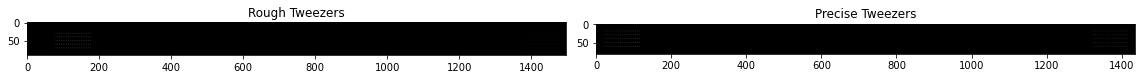

In [17]:
opt_tweezers_precise = simulatefourier(optimizedout.get_slmphase(), magnification=3)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
tweezers_rough = zoomin(removeleftside(remove0thorder(optimizedout.get_stdint())),20000).get()
tweezers_precise =  zoomin(removeedges(remove0thorder(opt_tweezers_precise)),20000).get()
axs[0].imshow(tweezers_rough, cmap='gray')
axs[0].set_title('Rough Tweezers')
axs[1].imshow(tweezers_precise, cmap='gray')
axs[1].set_title('Precise Tweezers')
plt.tight_layout()
plt.show()

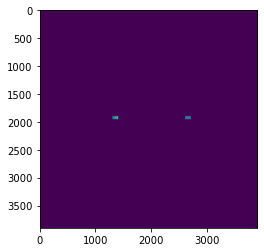

In [41]:
plt.imshow(gaussian_filter(opt_tweezers_precise.get(),3))

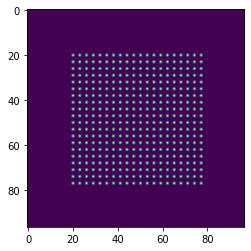

In [39]:
plt.imshow(zoomin(tweezerarray).get())